<a href="https://colab.research.google.com/github/LizaGomes97/Agente-IA-Portifolio/blob/main/Agente_Portifolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install -q --upgrade langchain langchain-google-genai google-generativeai

In [43]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')

In [44]:
llm = ChatGoogleGenerativeAI (
    model = 'gemini-2.5-flash',
    temperature = 0,
    api_key= GOOGLE_API_KEY
)

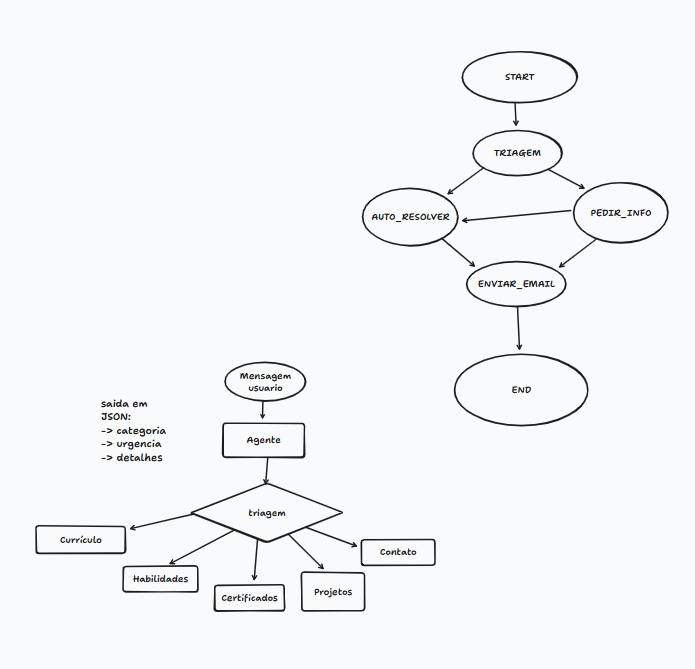

In [45]:
TRIAGEM_PROMPT ={
    """
    Voce é um assistente do portifolio de Lizandra Ribeiro Gomes Placido dos Santos e seu objetivo é ajudar os usuarios que entram no portifolio a encontrar o que buscam e tirar suas duvidas, no fim do atendimento voce sempre vai informar a Lizandra tudo o que aconteceu em sua conversa.
    Lizandra tem sua propria empresa a CodeStorm na qual ela realiza trabalhos autonomos e ela tambem tem outras experiencias (veja no curriculo)
    Dada a mensagem do usuario, retorne SOMENTE um JSON com:
    {
      "decisao": "AUTO_RESOLVER" | "PEDIR_INFO" | "ENVIAR_EMAIL",
      "urgencia": "BAIXA" | "MEDIA" | "ALTA",
      "detalhes": ["..."]
    }
    Regras:
    - **AUTO_RESOLVER**: Perguntas claras sobre curriculo, habilidades, certificados, projetos ou forma de entrar em contato descritas nos curriculos. (Ex: "Voce possui habilidade com Python?", "Qual seu nivel de habilidade com Front-End?", "Quanto tempo voce tem desenvolvendo projetos full-stack?").
    - **PEDIR_INFO**: Mensagens vaagas ou que faltam informações para identificar o tema ou o contexto (Ex: "Tenho uma duvida", "Quero informações")
    - **ENVIAR_EMAIL**: Após encerrar o atendimento do usuario ou quando o usuario pede para entrar em contato com Lizandra (Ex:"Gostaria de conversar com você", "Achei seu projeto muito interessante, vamos nos conectar", "Tenho uma proposta para voce")
    """
}

In [46]:
from pydantic import BaseModel, Field
from typing import Literal, List, Dict

class TriagemOut(BaseModel):
    decisao: Literal[
        "AUTO_RESOLVER",
        "PEDIR_INFO",
        "ENVIAR_EMAIL"
    ]
    urgencia: Literal[
        "BAIXA",
        "MEDIA",
        "ALTA"
    ]
    detalhes: List[str] = Field(default_factory=list)

In [47]:
llm_triagem = ChatGoogleGenerativeAI (
    model = 'gemini-2.5-flash',
    temperatura = 0,
    api_key= GOOGLE_API_KEY
)

In [48]:
from langchain_core.messages import SystemMessage, HumanMessage

triagem_chain = llm_triagem.with_structured_output(TriagemOut)

def triagem(mensagem: str) -> Dict:
  saida : TriagemOut = triagem_chain.invoke([
      SystemMessage(content = TRIAGEM_PROMPT),
      HumanMessage(content = mensagem)
  ])

  return saida.model_dump()

In [49]:
testes = [
    "Quais são as principais habilidades da Lizandra?",
    "A Lizandra tem experiência com desenvolvimento web?",
    "Quais projetos a Lizandra já desenvolveu?",
    "Como posso entrar em contato com a Lizandra?",
    "A Lizandra possui certificações?",
    "Quero mais informações",
    "Tenho uma duvida"
]

In [ ]:
for msg_test in testes:
  print(f"Pergunta: {msg_test}\n -> Resposta: {triagem(msg_test)}\n")

In [ ]:
!pip install -q --upgrade langchain_community faiss-cpu langchain-text-splitters pymupdf

In [ ]:
from pathlib import Path
from langchain_community.document_loaders import PyMuPDFLoader

curriculos = []

for n in Path("/content/").glob("*.pdf"):
  try:
    loader = PyMuPDFLoader(str(n))
    curriculos.extend(loader.load())
    print(f"Carregado com sucesso o arquivo {n.name}")
  except Exception as e:
    print(f"Erro ao carregar o arquivo {n.name}: {e}")

print(f"Total de páginas carregadas: {len(curriculos)}")

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

#Aqui definimos como vamos dividir o documento, nesse caso esta a cada 300 caracteres com o overlap (tantinho do anterior e do proximo) de 30
splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=30)
#Aqui selecionamos a lista dos documentos que crimaos anteriomente
chunks = splitter.split_documents(curriculos)

In [ ]:
for chunk in chunks:
  print(chunk)
  print("----------------------------------------------\n")

In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model = "models/gemini-embedding-001",
    google_api_key= GOOGLE_API_KEY
    )

In [ ]:
from re import search
from langchain_community.vectorstores import FAISS

#------------------------------os pedaços, com o modelo embeddings
vectorstore = FAISS.from_documents(chunks, embeddings)

retriever = vectorstore.as_retriever(search_type = "similarity_score_threshold",
                                    search_kwargs = {"score_threshold": 0.3,
                                                     "k":4}
                                    )

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain

prompt_rag = ChatPromptTemplate.from_messages([
    ("system",
     """
    Você é um Assistente para usuarios que entrem no portifolio da empresa CodeStorm da programadora Lizandra Santos.
    Responda SOMENTE com base no contexto fornecido.
    Se não houver contexto suficiente para responder a pergunta, responda "Não sei".
    """),

    ("human",
    """
    Pergunta: {input}\n\nContexto:\n{context}
    """)
])

document_chain = create_stuff_documents_chain(llm_triagem, prompt_rag)

In [ ]:
# Formatadores
import re, pathlib

def _clean_text(s: str) -> str:
    return re.sub(r"\s+", " ", s or "").strip()

def extrair_trecho(texto: str, query: str, janela: int = 240) -> str:
    txt = _clean_text(texto)
    termos = [t.lower() for t in re.findall(r"\w+", query or "") if len(t) >= 4]
    pos = -1
    for t in termos:
        pos = txt.lower().find(t)
        if pos != -1: break
    if pos == -1: pos = 0
    ini, fim = max(0, pos - janela//2), min(len(txt), pos + janela//2)
    return txt[ini:fim]

def formatar_citacoes(docs_rel: List, query: str) -> List[Dict]:
    cites, seen = [], set()
    for d in docs_rel:
        src = pathlib.Path(d.metadata.get("source","")).name
        page = int(d.metadata.get("page", 0)) + 1
        key = (src, page)
        if key in seen:
            continue
        seen.add(key)
        cites.append({"documento": src, "pagina": page, "trecho": extrair_trecho(d.page_content, query)})
    return cites[:3]

In [ ]:
def perguntar_informacoes_RAG(pergunta: str) -> Dict:
    docs = retriever.get_relevant_documents(pergunta)

    if not docs:
      return{
          "answer": "Não sei",
          "citacoes": [],
          "contexto_encontrado": False
      }
    answer = document_chain.invoke({
        "input": pergunta,
        "context": docs
    })

    txt = (answer or '').strip()

    if txt.rstrip('.!?') == "Não sei":
      return{
          "answer": "Não sei",
          "citacoes": [],
          "contexto_encontrado": False
      }

    return{
        "answer": txt,
        "citacoes": formatar_citacoes(docs, pergunta),
        "contexto_encontrado": True
    }

In [ ]:
for msg_test in testes:
  resposta = perguntar_informacoes_RAG(msg_test)
  print(f"PERGUNTA:{msg_test}")
  print(f"RESPOSTA: {resposta['answer']}")
  if resposta['contexto_encontrado']:
    print(f"CITAÇÕES:")
    for c in resposta ['citacoes']:
      print(f"Documento: {c['documento']}")
      print(f"Página: {c['pagina']}")
      print(f"Trecho: {c['trecho']}")
    print("------------------------------------------------")

In [ ]:
!pip install -q --upgrade langgraph

In [ ]:
from typing import TypedDict, Optional

class AgentState(TypedDict, total = False):
  pergunta: str
  triagem: dict
  resposta: Optional [str]
  citacoes: List[dict]
  rag_sucesso: bool
  acao_final: str

In [ ]:
def node_triagem(state: AgentState) -> AgentState:
  print("Executando nó triagem...")
  return {"triagem": triagem(state["pergunta"])}

In [ ]:
def node_auto_resolver(state: AgentState) -> AgentState:
  print("Executando nó auto resolver...")
  resposta_rag = perguntar_informacoes_RAG(state["pergunta"])

  update: AgentState = {
      "resposta": resposta_rag["answer"],
      #pega citações e guarda em uma lista vazia
      "citacoes": resposta_rag.get("citacoes", []),
      "rag_sucesso": resposta_rag["contexto_encontrado"],
  }

  if  resposta_rag["contexto_encontrado"]:
    update["acao_final"] = "AUTO_RESOLVER"

  return update


In [ ]:
def node_pedir_info (state:AgentState) -> AgentState:
  print("Executando o nó de pedir info... ")
  faltantes = state["triagem"].get("campos_faltantes",[])

  #Se existem dados faltantes na triagem que pegamos do get
  #Pega todos eles e separa por virgula
  #Se nao retorna o else
  detalhe = ",".join(faltantes) if faltantes else "Tema e contexto específico"

  return{"resposta": f"Para avançar, preciso de mais informações sobre {detalhe}",
         "citacoes": [],
         "acao_final": "PEDIR_INFO"
         }

In [ ]:
def node_enviar_email(state: AgentState) -> AgentState:
  print("Executando nó enviar email...")
  triagem = state["triagem"]

  return{
      "resposta": f"Enviarei um email para Lizandra para ela entrar em contato com você. Descrição: {state['pergunta'][:140]}",
      "citacoes": [],
      "acao_final": "ENVIAR_EMAIL"
  }

In [ ]:
KEYWORDS_ABRIR_TICKED = ["contate-me","conversar","comigo"]

def decidir_pos_triagem(state: AgentState) -> str:
  print("Decidi após a triagem...")
  decisao = state["triagem"]["decisao"]

  if decisao == "AUTO_RESOLVER": return "auto"
  if decisao == "PEDIR_INFO": return "info"
  if decisao == "ENVIAR_EMAIL": return "email"

In [ ]:
def decidir_pos_autoresolver(state: AgentState) -> str:
  print("Decidi após o auto_resolver...")
  if state.get("rag_sucesso"):
    print("Rag com sucesso, finalizando o fluxo.")
    return "ok"

  #aqui vamos recuperar a pergunta
  state_da_pergunta = (state["pergunta"] or "").lower()

  #se der ok vai para o final, se nao pega a pergunta para mim
  #e verifica se tem alguma dessas palavras para eu retornar abrir chamado
  if any(k in state_da_pergunta for k in KEYWORDS_ABRIR_TICKED):
    print("Rag falhou, mas foi encontrado uma keyworld de envio de email. Enviando...")
    return "email"

  print("Rag falhou, sem keyworlds, por favor mandar mais informações...")
  return "info"

In [ ]:
from langgraph.graph import StateGraph, START, END

# "Respeite esse AgentState"
workflow = StateGraph(AgentState)

workflow.add_node("triagem", node_triagem)
workflow.add_node("auto_resolver", node_auto_resolver)
workflow.add_node("pedir_info", node_pedir_info)
workflow.add_node("enviar_email", node_enviar_email)

workflow.add_edge(START, "triagem")
workflow.add_conditional_edges("triagem", decidir_pos_triagem, {
    "auto":"auto_resolver",
    "info":"pedir_info",
    "email":"enviar_email"
})

workflow.add_conditional_edges("auto_resolver", decidir_pos_autoresolver, {
    "info":"pedir_info",
    "email":"enviar_email",
    "ok": END
})

workflow.add_edge("pedir_info", END)
workflow.add_edge("enviar_email", END)

grafo = workflow.compile()


In [ ]:
from IPython.display import display, Image

graph_bytes = grafo.get_graph().draw_mermaid_png()
display(Image(graph_bytes))

In [ ]:
for msg_test in testes:
  resposta_final= grafo.invoke({"pergunta": msg_test})

  triag = resposta_final.get("triagem",{})

  print(f"PERGUNTA: {msg_test}")
  print(f"DECISÃO: {triag.get('decisao',)} | URGÊNCIA: {triag.get('urgencia')} | AÇÃO FINAL: {resposta_final.get('acao_final')}")
  print(f"RESPOSTA: {resposta_final.get('resposta')}")

  if resposta_final.get("citacoes"):
    print("CITAÇÕES:")
    for citacao in resposta_final.get("citacoes"):
        print(f"Documento: {citacao['documento']}")
        print(f"Página: {citacao['pagina']}")
        print(f"Trecho: {citacao['trecho']}")
  print("------------------------------------------------")